In [1]:
import pybinding as pb
from BerryEasy import BerryEasy as be
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

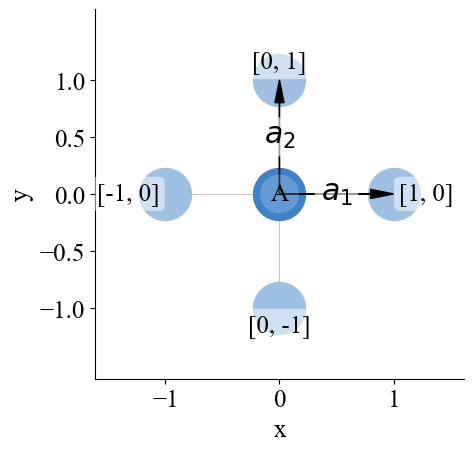

In [4]:
#Define Matrices:
s0=np.diag([1,1])
s1 = np.array([[0,1],[1,0]])
s2 = np.array([[0,-1j],[1j,0]])
s3 = np.diag([1,-1])

g_1=np.kron(s1,s1)
g_2=np.kron(s1,s2)
g_3=np.kron(s3,s0)

U=-1.5*g_3
Tx=(1j*g_1+g_3)/2
Ty=(1j*g_2+g_3)/2
#Tz=(1j*g_3+g_5)/2
lat=pb.Lattice(a1=[1,0],a2=[0,1])
lat.add_sublattices(('A', [0,0],U))
lat.add_hoppings(                 
                 ([1,0], 'A', 'A', Tx),
                 ([0,1], 'A', 'A', Ty)
                )
lattice = lat
lattice.plot()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('Unit_Cell.png')
plt.show()


Text(0.5, 0, '')

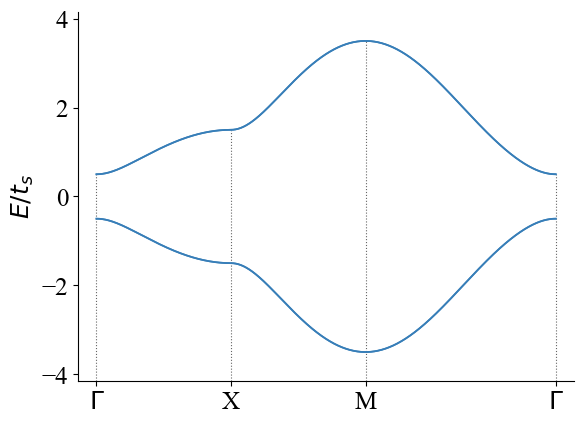

In [5]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})
model = pb.Model(lat,
            pb.force_double_precision(),         
            pb.translational_symmetry(a1=True, a2=True, a3=True))
solver = pb.solver.lapack(model)

from math import pi
X = [pi,0,0]
Gamma = [0,0,0]
M= [pi,pi,0]

bands = solver.calc_bands( Gamma, X, M, Gamma,step=0.01)
bands.plot(point_labels=[ r'$\Gamma$', 'X', 'M', r'$\Gamma$'])
plt.ylabel(r'$E/t_{s}$')
plt.xlabel('')

# Now let us create a supercell and introduce a vacancy

In [6]:
def vacancy(position, radius):
    @pb.site_state_modifier
    def modifier(state, x, y):
        x0, y0 = position
        state[(x-x0)**2 + (y-y0)**2 < radius**2] = False
        return state
    return modifier

# Introduce vacancy through pybinding onsite modifier and compute the density of states under PBCs to ensure the bulk gap has not closed


  0%|          | 0/6 [00:00<?, ?it/s]

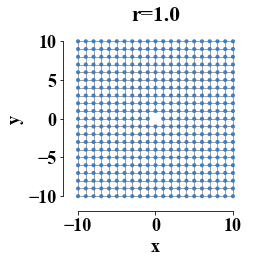


 17%|█▋        | 1/6 [00:03<00:17,  3.54s/it]

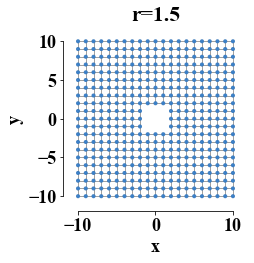


 33%|███▎      | 2/6 [00:05<00:12,  3.17s/it]

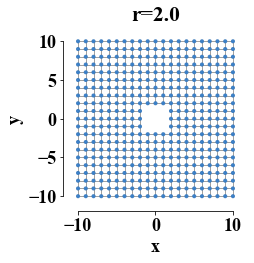


 50%|█████     | 3/6 [00:08<00:08,  2.88s/it]

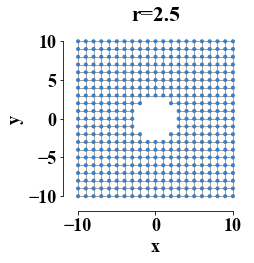


 67%|██████▋   | 4/6 [00:10<00:05,  2.78s/it]

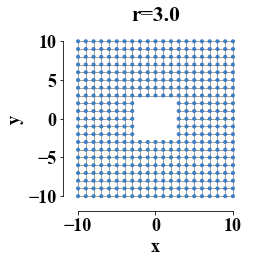


 83%|████████▎ | 5/6 [00:13<00:02,  2.72s/it]

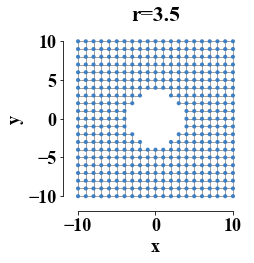


100%|██████████| 6/6 [00:16<00:00,  2.70s/it]


In [27]:
BulkAvgDos=[]
L=21
for r in tqdm(np.linspace(1,3.5,6)):
    model = pb.Model(lat,
        pb.primitive(L,L),
         vacancy([0,0],r),    
        pb.force_double_precision(),
        pb.translational_symmetry(a1=L, a2=L))
    solver = pb.solver.arpack(model,100)
    ldos = solver.calc_dos(np.linspace(-2,2,201), broadening=0.02)
    result=getattr(ldos,'data')
    BulkAvgDos.append(result)
    model.plot(num_periods=0)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('r='+str(r))
    plt.tight_layout()
    plt.savefig('Lat_r'+str(r)+'.png',bbox_inches='tight')
    plt.show()

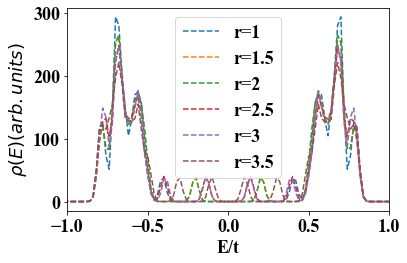

In [28]:
plt.plot(np.linspace(-2,2,201),BulkAvgDos[0],'--')
plt.plot(np.linspace(-2,2,201),BulkAvgDos[1],'--')
plt.plot(np.linspace(-2,2,201),BulkAvgDos[2],'--')
plt.plot(np.linspace(-2,2,201),BulkAvgDos[3],'--')
plt.plot(np.linspace(-2,2,201),BulkAvgDos[4],'--')
plt.plot(np.linspace(-2,2,201),BulkAvgDos[5],'--')
plt.legend(['r=1','r=1.5','r=2','r=2.5','r=3','r=3.5'])
plt.xlim(-1,1)
plt.ylabel(r'$\rho(E) (arb. units)$')
plt.xlabel('E/t')
plt.tight_layout()
plt.savefig('DOS_Defect.png',bbox_inches='tight')
plt.show()

# Now let us compute the WCC spectra for the slab with a defect

In [7]:
#Note that L=21 is used in paper, the computation requires more significant time, the system size is limited here for that reason
L=5
avgres=[]
#avgres2=[]
for r in tqdm([.5,1,1.5]):
    model = pb.Model(lat,
        pb.primitive(L,L),
         vacancy([0,0],r),    
        pb.force_double_precision(),
        pb.translational_symmetry(a1=L, a2=L))
    solver = pb.solver.lapack(model)
    rvec0=np.diag([2*np.pi/L,2*np.pi/L,2*np.pi/L])
    vec=lambda t1, t2: [t1, t2, 0]
    ds=10
    ds2=20
    bnds=range(int(2*L*L))
    WCCx=be.WSurf(vec,model,bnds,ds,ds2,rvec0)
    avgres.append(WCCx)


100%|█████████████████████████████████████████████| 3/3 [00:06<00:00,  2.03s/it]


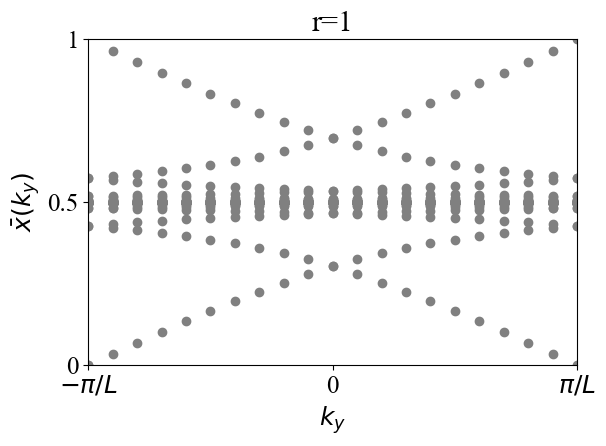

In [8]:
plt.plot(avgres[0],'o',c='gray')
plt.ylim(-np.pi,np.pi)
plt.xlabel(r'$k_{y}$')
plt.title('r=1')
plt.ylabel(r'$\bar{x}(k_{y})$')
plt.yticks([-np.pi,0,np.pi],[0,'0.5','1'])
plt.xticks([0,10,20],['$-\pi/L$','0','$\pi/L$'])
plt.xlim(0,20)
plt.tight_layout()
plt.show()